# GeeksForGeeks Data Analysis 

## All Imports

In [1]:
import pandas
import numpy as np
import seaborn as sns
import requests
from bs4 import BeautifulSoup

### -Importing Dataset

In [2]:
df=pandas.read_csv("medals.csv")

## Exploring The Data

In [3]:
df.columns

Index(['discipline_title', 'slug_game', 'event_title', 'event_gender',
       'medal_type', 'participant_type', 'participant_title', 'athlete_url',
       'athlete_full_name', 'country_name', 'country_code',
       'country_3_letter_code'],
      dtype='object')

In [4]:
df.head()

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,participant_title,athlete_url,athlete_full_name,country_name,country_code,country_3_letter_code
0,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy,https://olympics.com/en/athletes/stefania-cons...,Stefania CONSTANTINI,Italy,IT,ITA
1,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy,https://olympics.com/en/athletes/amos-mosaner,Amos MOSANER,Italy,IT,ITA
2,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway,https://olympics.com/en/athletes/kristin-skaslien,Kristin SKASLIEN,Norway,NO,NOR
3,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway,https://olympics.com/en/athletes/magnus-nedreg...,Magnus NEDREGOTTEN,Norway,NO,NOR
4,Curling,beijing-2022,Mixed Doubles,Mixed,BRONZE,GameTeam,Sweden,https://olympics.com/en/athletes/almida-de-val,Almida DE VAL,Sweden,SE,SWE


In [5]:
df.describe()

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,participant_title,athlete_url,athlete_full_name,country_name,country_code,country_3_letter_code
count,21697,21697,21697,21697,21697,21697,6584,17027,18073,21697,20195,21697
unique,86,53,1436,4,3,2,493,12116,12895,154,143,154
top,Athletics,tokyo-2020,Individual men,Men,BRONZE,Athlete,United States team,https://olympics.com/en/athletes/michael-phelp...,Michael PHELPS,United States of America,US,USA
freq,3080,1188,215,13932,7529,15113,523,16,16,3094,3094,3094


### -Checking For Possible Values Of Some Columns

In [6]:
# possible values of participant_type
set(df.participant_type)

{'Athlete', 'GameTeam'}

In [7]:
# possible values of event_gender
set(df.event_gender)

{'Men', 'Mixed', 'Open', 'Women'}

In [8]:
# possible values of medal_type
set(df.medal_type)

{'BRONZE', 'GOLD', 'SILVER'}

## Preprocessing The Data

### -Cleaning The Data

In [9]:
# Checking for null values
for i in df.columns:
    if df[i].isnull().any():
        print(i)

participant_title
athlete_url
athlete_full_name
country_code


In [10]:
df['participant_title'].isnull().sum()

15113

In [11]:
df['participant_title'].size

21697

<Axes: >

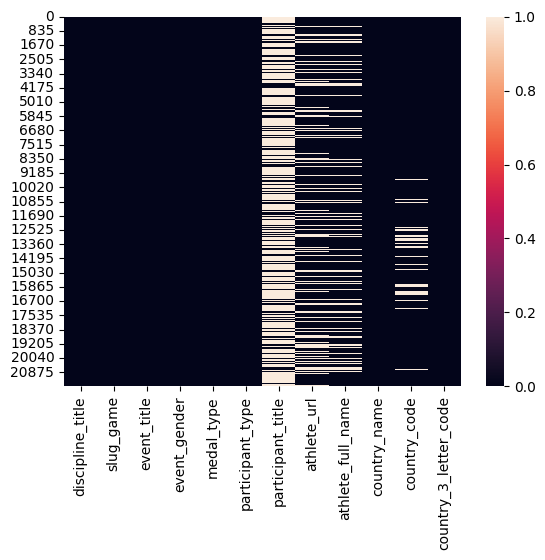

In [12]:
# Checking all null values more clearly
sns.heatmap(df.isnull())
# We can fill up country codes later on as we have 3 letter code, so for now, we will ignore that and fix the others

In [13]:
# common nulls between participant title and athlete full name and athlete url
p_af_url=0
# common nulls between participant title and athlete full name
p_af=0
# common nulls between participant title and athlete url
p_url=0
for i in df.index:
    if str(df['participant_title'][i])=="nan" and str(df['athlete_full_name'][i])=="nan" and str(df['athlete_url'][i])=="nan":
        p_af_url+=1
    elif str(df['participant_title'][i])=="nan" and str(df['athlete_full_name'][i])=="nan":
        p_af+=1
    elif str(df['participant_title'][i])=="nan" and str(df['athlete_url'][i])=="nan":
        p_url+=1  

In [14]:
print(p_af_url)
print(p_url)
print(p_af)

0
888
0


### Filling up blank athlete_full_names with athlete_url

In [15]:
def to_camel_case(text):
    newString=""
    for ind,i in enumerate(text):
        if ind==0:
            newString+=i.upper()
        else:
            newString+=i
    return newString

# Athlete names
for i in df.index:
    athleteUrl=df['athlete_url'][i]
    
#     A reason is given below in the markdown for this
    if type(athleteUrl)!=float and type(df['athlete_full_name'][i])==float:
        
#         Removing unnecessary parts
        athleteUrl=athleteUrl.replace("https://olympics.com/en/athletes/","")
        athleteUrl=athleteUrl.replace("-"," ")
        athleteName=""
#         Working with string cases
        athleteUrl=athleteUrl.split(" ")
#     Camel case
        if len(athleteUrl)==1:
            athleteName=to_camel_case(athleteUrl[0])
        else:
            
            for ind,name in enumerate(athleteUrl):
                if ind==0:
                    athleteName+=to_camel_case(athleteUrl[0])+" "
                else:
#                     Capital case

                    if ind!=len(athleteUrl)-1:
                        athleteName+=name.upper()+" "
                    else:
                        athleteName+=name.upper()
            
#         print(athleteName)
        df['athlete_full_name'][i]=athleteName        


In the above code, we have mentioned a condition like 
#### if type(athleteUrl)!=float and type(df['athlete_full_name'][i])==float
This suggests that we only want to fill up the athlete names which are not prefilled, and we also want to ignore the NULL urls

In [16]:
# Checking for any single word names (names without title)
for i in df.index:
    if type((df.athlete_full_name[i]))!=float:
        if len(df.athlete_full_name[i].split(" "))==1:
            print(i)
# There are no such values

### Filling up blank participant_titles with athlete_full_name

In [17]:
for i in df.index:
    a=df.participant_title[i]
    if type(a)!=float:
        print(i," ",a)
        
# We can see , we need to substitude the null values of participant_titles with country name + " team"
# as we dont know whether its a duo or not, or what are their names.

0   Italy
1   Italy
2   Norway
3   Norway
4   Sweden
5   Sweden
6   Great Britain
7   Japan
8   Sweden
9   Sweden
10   Great Britain
11   Canada
30   United States
31   China
32   Canada
57   Canada
58   Republic of Korea
59   Italy
60   People's Republic of China
61   Italy
62   Hungary
69   Netherlands
70   Republic of Korea
71   People's Republic of China
81   United States of America 1
82   United States of America 1
83   Italy 1
84   Italy 1
85   Canada 1
86   Canada 1
114   Austria
115   Slovenia
116   Germany
120   Slovenia
121   ROC
122   Canada
129   ROC
130   ROC
131   United States of America
132   Japan
133   SUI Wenjing / HAN Cong
134   SUI Wenjing / HAN Cong
135   TARASOVA Evgenia / MOROZOV Vladimir
136   TARASOVA Evgenia / MOROZOV Vladimir
137   MISHINA Anastasia / GALLIAMOV Aleksandr
138   MISHINA Anastasia / GALLIAMOV Aleksandr
139   PAPADAKIS Gabriella / CIZERON Guillaume
140   PAPADAKIS Gabriella / CIZERON Guillaume
141   SINITSINA Victoria / KATSALAPOV Nikita
142   

6966   United States team #2
6967   United States team #2
6968   United States team #1
6969   United States team #1
6973   Canada team
6974   United States team
6975   Sweden team
6976   Canada team
6977   United States team
6978   Russian Federation team
6985   France team #1
6986   France team #1
6987   Russian Federation team #1
6988   Russian Federation team #1
6989   Italy team #1
6990   Italy team #1
6991   Russian Federation team #1
6992   Russian Federation team #1
6993   Canada team #1
6994   Canada team #1
6995   People's Republic of China team #1
6996   People's Republic of China team #1
7030   Finland team
7031   Germany team
7032   Austria team
7051   Germany team
7052   Norway team
7053   Switzerland team
7066   Norway team
7067   Italy team
7068   Germany team
7090   Great Britain team
7091   Switzerland team
7092   Canada team
7093   Norway team
7094   Canada team
7095   Switzerland team
7096   United States team #2
7097   United States team #2
7098   Germany team #1
70

18410   Germany team
18411   Great Britain team
18412   Switzerland team
18413   Germany team
18414   Germany team
18415   Denmark team
18416   Denmark team
18417   Argentina team
18418   Argentina team
18419   Germany team
18420   Switzerland team
18421   France team
18449   Czechoslovakia team
18450   Czechoslovakia team
18451   Austria team
18452   Austria team
18453   Canada team
18454   Canada team
18455   Austria team
18456   Austria team
18457   Germany team
18458   Germany team
18459   Netherlands team
18460   Netherlands team
18480   Germany team
18481   Czechoslovakia team
18482   Hungary team
18489   Germany team
18490   Switzerland team
18491   Finland team
18495   India team
18496   Germany team
18497   Netherlands team
18525   Germany team
18526   France team
18527   Sweden team
18528   Netherlands team
18529   Germany team
18530   United States team
18558   Japan team
18559   United States team
18560   Hungary team
18561   United States team
18562   Canada team
18563   M

In [18]:
for i in df.index:
    countryN=df.country_name[i]
    if type(countryN)!=float and type(df.participant_title[i])==float:
        df.participant_title[i]=countryN+" team"

#     Also filling the rows which have country names but not the word "team"
    if type(countryN)!=float:
        if df.participant_title[i]!=float and "/" not in df.participant_title[i] and "team" not in df.participant_title[i]:
            df.participant_title[i]+=" team"
        

In [19]:
df.head(50)

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,participant_title,athlete_url,athlete_full_name,country_name,country_code,country_3_letter_code
0,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy team,https://olympics.com/en/athletes/stefania-cons...,Stefania CONSTANTINI,Italy,IT,ITA
1,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy team,https://olympics.com/en/athletes/amos-mosaner,Amos MOSANER,Italy,IT,ITA
2,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway team,https://olympics.com/en/athletes/kristin-skaslien,Kristin SKASLIEN,Norway,NO,NOR
3,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway team,https://olympics.com/en/athletes/magnus-nedreg...,Magnus NEDREGOTTEN,Norway,NO,NOR
4,Curling,beijing-2022,Mixed Doubles,Mixed,BRONZE,GameTeam,Sweden team,https://olympics.com/en/athletes/almida-de-val,Almida DE VAL,Sweden,SE,SWE
5,Curling,beijing-2022,Mixed Doubles,Mixed,BRONZE,GameTeam,Sweden team,https://olympics.com/en/athletes/oskar-eriksson,Oskar ERIKSSON,Sweden,SE,SWE
6,Curling,beijing-2022,Women,Women,GOLD,GameTeam,Great Britain team,NaN,NaN,Great Britain,GB,GBR
7,Curling,beijing-2022,Women,Women,SILVER,GameTeam,Japan team,NaN,NaN,Japan,JP,JPN
8,Curling,beijing-2022,Women,Women,BRONZE,GameTeam,Sweden team,NaN,NaN,Sweden,SE,SWE
9,Curling,beijing-2022,Men,Men,GOLD,GameTeam,Sweden team,NaN,NaN,Sweden,SE,SWE


In [20]:
df['athlete_full_name'].isnull().sum()

3624

<Axes: >

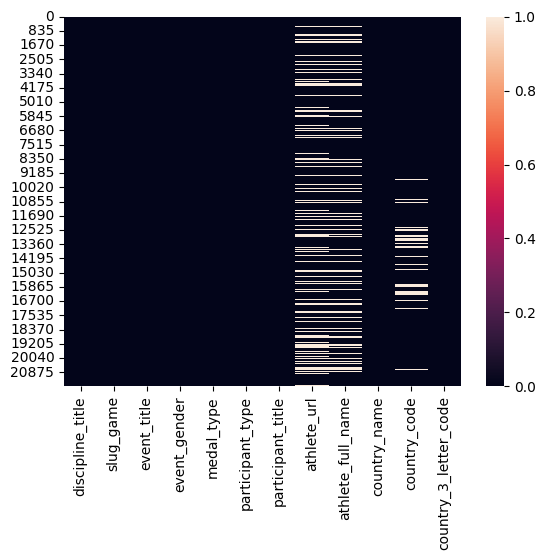

In [22]:
# Using heatmap again to check the progress
sns.heatmap(df.isnull())

## Team members:

#### Shibam Roy 
role: Data Analyst
#### Ankush Roy
role: Data Analyst
#### Debdutta Barman 
role: Frontend developer